# Quick plot for comparing e-values under null vs alternative

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import comparecast as cc
cc.set_theme()

rng = np.random.default_rng(20241028)

In [2]:
def make_beta(T, mu=0.75, init_mean=0.5):
    """Generate samples from Beta(mu, 1-mu), and 
    also pre-compute mean and variance estimates."""
    
    times = np.arange(1, T + 1)
    ys = rng.beta(mu, 1 - mu, size=T)
    
    sums = np.cumsum(ys)
    means = sums / times
    pred_means = means.copy()
    pred_means[1:], pred_means[0] = means[:-1], init_mean
    
    pred_vs = np.cumsum((ys - pred_means) ** 2)
    
    return pd.DataFrame({
        "t": times,
        "y": ys,
        "pred_m": pred_means,
        "pred_v": pred_vs,
    })

In [3]:
from confseq.betting_strategies import lambda_aKelly

def log_wealth_aKelly(ys, m):
    bets = lambda_aKelly(ys, m)
    return np.cumsum(np.log(1.0 + bets * (ys - m)))

## Plot null vs alt

- Null (H0): $\mu = 0.5$
- Alt case (H1): $\mu = 0.4$

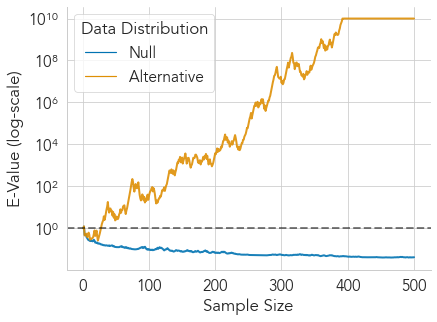

In [4]:
mu = 0.5  # test martingale
T = 500
gap = 0.1
max_wealth = np.log(10**10)

dfs = []
for m, name in [(mu, "Null"), (mu - gap, "Alternative")]:
    m = np.round(m, 2)
    data = make_beta(T, m)
    log_wealth = log_wealth_aKelly(data.y, mu)
    dfs.append(pd.DataFrame({
        "Sample Size": data.t,
        "m": [m for _ in range(T)],
        "Data Distribution": [name for _ in range(T)],
        "E-Value": np.exp(np.minimum(log_wealth, max_wealth)),
    }))
wealth = pd.concat(dfs, axis=0, ignore_index=True)
fg = sns.relplot(
    x="Sample Size",
    y="E-Value",
    hue="Data Distribution",
    kind="line",
    linewidth=2,
    alpha=0.9,
    aspect=1.25,
    # palette="crest",
    data=wealth,
    facet_kws={"legend_out": False},
)
fg.ax.set(yscale="log", ylabel="E-Value (log-scale)")
fg.ax.axhline(y=1, linewidth=2, color="black", linestyle="--", alpha=0.5)
fg.savefig("evalues_null_vs_alternative.png", dpi=350)
fg.savefig("evalues_null_vs_alternative.pdf")
None